# Définition du modèle de base

In [1]:
import gurobipy as gp
import pandas as pd
import numpy as np
from gurobipy import Model
model = Model ( "Projet" )
model.modelSense = gp.GRB.MINIMIZE
#Périodes


Periodes, dur, d = gp.multidict( {
    0: [6, 15000],
    1: [3, 30000],
    2: [6, 25000],
    3: [3, 40000],
    4: [6, 27000], } )


Set parameter TokenServer to value "dev.cma.mines-paristech.fr"


### Centrales

### 5-1. Centrales hydroélectriques

### 5-3. Intégration des variables des paliers de fonctionnement des centrales hydrauliques

In [2]:
C1, P1, Ab1, Cout1 = gp.multidict( {
    0: [900.0, 0.31, 90],
    1: [950.0, 0.33, 95],
    2: [1000.0, 0.35, 105],
    3: [1100.0, 0.38, 120],} )

C2, P2, Ab2, Cout2 = gp.multidict( {
    0: [1400.0, 0.47, 150],
    1: [1500.0, 0.50,165],
    2: [1600.0, 0.53, 185],
    3: [1700.0, 0.56, 210],} )

#Vitesse d'abaissement et coûts
vab1 = model.addVar(lb=0, vtype=gp.GRB.CONTINUOUS)
ct1 = model.addVar(lb=0, vtype=gp.GRB.CONTINUOUS)

vab2 = model.addVar(lb=0, vtype=gp.GRB.CONTINUOUS)
ct2 = model.addVar(lb=0, vtype=gp.GRB.CONTINUOUS)

#Variables binaire choix du palier
s1 = {(t,i): model.addVar(lb = 0,ub=1, vtype=gp.GRB.INTEGER) for t in range(len(d)) for i in range(len(C1))}
s2 = {(t,i): model.addVar(lb = 0,ub=1, vtype=gp.GRB.INTEGER) for t in range(len(d)) for i in range(len(C1))}

In [3]:
#Variables modèle
TYPE, nbT, Pmin, Pmax, cst, Cstart, Cbase, Vab, Celev = gp.multidict( {
    'A': [12, 850, 2000, 2.0, 2000, 1000, 0, 0],
    'B': [10, 1250,1750, 1.3, 1000, 2600, 0, 0],
    'C': [5, 1500, 4000, 3.0, 500, 3000, 0, 0],
    'H1': [1, 900, 1100, 0, 1500, ct1, vab1, 3000],
    'H2': [1, 1400, 1700, 0, 1200, ct2, vab2, 3000],} )

# 1-1. Planification journalière

### Variables

In [4]:

#Nombre total de centrales activées
X = {(t,a): model.addVar(lb = 0, vtype=gp.GRB.INTEGER) for t in range(len(d)) for a in TYPE}

#Coût d'activation par type
st = {(t,a): model.addVar(lb = 0, vtype=gp.GRB.INTEGER) for t in range(len(d)) for a in TYPE}
#Production d'énergie de chaque centrale
PROD = {(t,a): model.addVar(lb = 0, vtype=gp.GRB.CONTINUOUS) for t in range(len(d)) for a in TYPE}


## Contraintes

In [5]:
#Contraintes production
CSTR_X = {(t,a) : model.addConstr(X[t,a] <= nbT[a]) for t in range(len(d)) for a in TYPE}

CSTR_min = {(t,a): model.addConstr(PROD[t,a]>= X[t,a]*Pmin[a]) for t in range(len(d)) for a in TYPE}

CSTR_max = {(t,a): model.addConstr(PROD[t,a]<= X[t,a]*Pmax[a]) for t in range(len(d)) for a in TYPE}

### Contrainte de puissance (variable)

### 3-1. Réserve de puissance

In [6]:
#Réserve de puissance
CSTR_rp = {(t): model.addConstr(sum(PROD[t,a] for a in TYPE) <= 0.85*sum(X[t,a]*Pmax[a] for a in TYPE)) for t in range(5)}


### 4-1. Option cyclique

In [7]:
option = 1
#Fonction cyclique
def prev(per,opt):
    r=per
    if opt == 0:
        return(r)
    else :
        return(r-1)
    
#Contraintes sur le nombre de centrales considéré au début de chaque journée
if option == 0:
    CSTR_st = {(a): model.addConstr(st[0,a] >= X[0,a] ) for a in TYPE}
    CSTR_st1 = {(t,a): model.addConstr(st[t,a] >= X[t,a]-X[prev(Periodes[t],option),a]) for t in range(1,len(d)) for a in TYPE}
else:
    CSTR_st = {(a): model.addConstr(st[0,a] >= X[0,a]-X[4,a] ) for a in TYPE} 
    CSTR_st1 = {(t,a): model.addConstr(st[t,a] >= X[t,a]-X[prev(Periodes[t],option),a]) for t in range(1,len(d)) for a in TYPE}


## 5-2. Pompage (Variable et contrainte)

In [8]:
#Quantité d'eau absorbée
H = {(t): model.addVar(lb = 0, vtype=gp.GRB.CONTINUOUS) for t in range(len(d))}

#Equilibre de la quantité d'eau
CSTR_H = model.addConstr(sum(H[t] for t in range(len(d))) >= sum(X[t,a]*dur[t]*Vab[a] for t in range(len(d)) for a in TYPE))

#Nouvelle contrainte de puissance
#CSTR_P = {(t,i): model.addConstr(sum(PROD[i,a] for a in TYPE ) >= d[i]+H[i]*Celev[t]/dur[i]) for i in range(len(d)) for t in TYPE}


## 5-3. Contraintes paliers de fonctionnement et variables binaires

In [9]:
#Contrainte unicité du choix
CSTR_s1 = {(t,a): model.addConstr(sum(s1[t,a] for a in C1)<=1) for t in range(len(d)) for a in TYPE}
CSTR_s2 = {(t,a): model.addConstr(sum(s2[t,a] for a in C1)<=1) for t in range(len(d)) for a in TYPE}

#-------------------------H1
CSTR_ph1 = {(t): model.addConstr(PROD[t,'H1']== sum(s1[t,j]*P1[j] for j in range(len(P1))) ) for t in range(len(d))}
CSTR_ab1 = {(t): model.addConstr(vab1 == sum(s1[t,j]*Ab1[j] for j in range(len(P1))) ) for t in range(len(d))}
CSTR_cs1 = {(t): model.addConstr(ct1 == sum(s1[t,j]*Cout1[j] for j in range(len(P1))) ) for t in range(len(d))}

#-------------------------H2
CSTR_ph2 = {(t): model.addConstr(PROD[t,'H2']== sum(s2[t,j]*P2[j] for j in range(len(P1))) ) for t in range(len(d))}
CSTR_ab2 = {(t): model.addConstr(vab2 == sum(s2[t,j]*Ab2[j] for j in range(len(P1))) ) for t in range(len(d))}
CSTR_cs2 = {(t): model.addConstr(ct2 == sum(s2[t,j]*Cout2[j] for j in range(len(P1))) ) for t in range(len(d))}


#Nouvelle contrainte de puissance
CSTR_P = {(t,i): model.addConstr(sum(PROD[i,a] for a in TYPE ) >= d[i]+H[i]*Celev[t]/dur[i]) for i in range(len(d)) for t in TYPE}


## 2-1. Modèle Cbase et Cmwh

## 2-2. Modèle Cbase, Cmwh et Cstart

In [10]:
#Modèle
model.setObjective(sum(X[j,i]*dur[j]*Cbase[i] + dur[j]*cst[i]*(PROD[j,i]-X[j,i]*Pmin[i])+st[j,i]*Cstart[i] 
                      for i in TYPE 
                      for j in range(len(d))),gp.GRB.MINIMIZE)
    
model.update()
model.optimize()        

#Résultats
print('_________________')

print('Variables  :', model.numVars)
print('Contraintes:', model.numConstrs)
print('_________________')

print('Coût total:', round(model.objVal, 2))


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 210 rows, 124 columns and 735 nonzeros
Model fingerprint: 0xa07b2fc0
Model has 10 quadratic objective terms
Model has 1 quadratic constraint
Variable types: 34 continuous, 90 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+03]
  QMatrix range    [3e+00, 6e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [4e+00, 9e+03]
  QObjective range [6e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 143 rows and 58 columns
Presolve time: 0.00s
Presolved: 72 rows, 70 columns, 264 nonzeros
Variable types: 24 continuous, 46 integer (10 binary)
Found heuristic solution: objective 1300825.0000

Root relaxation: objective 9.228966e+05, 39 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

<Figure size 432x288 with 0 Axes>

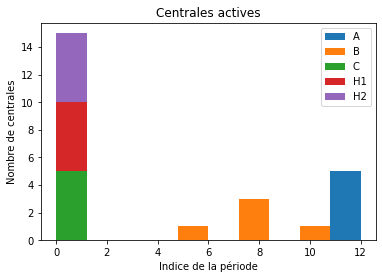

In [34]:
import numpy as np
import matplotlib.pyplot as plt

dict_al = {t : [int(X[p,t].x) for p in Periodes] for t in TYPE}
df_al = pd.DataFrame(dict_centrales_allumees)

plt.figure()
df_al.plot(kind='hist', stacked=True)
plt.title("Centrales actives")
plt.xticks(rotation=0)
plt.xlabel("Indice de la période")
plt.ylabel('Nombre de centrales')
plt.savefig('Centrales actives')
plt.show()

plt.show()